In [2]:
import os
import cv2
import geopandas as gpd
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
from skimage import io

data_path = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP-detection/data/kaggle_data"
train_path = os.path.join(data_path,'tiff/train')
test_path = os.path.join(data_path,'tiff/test')

train_images = glob(train_path+'/*.tiff')
test_images = glob(test_path+'/*.tiff')

print("Training images: ",len(train_images))
print("Testing images: ",len(test_images))
print("IMG_shape: 1500x1500x3\n")

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Training images:  137
Testing images:  10
IMG_shape: 1500x1500x3



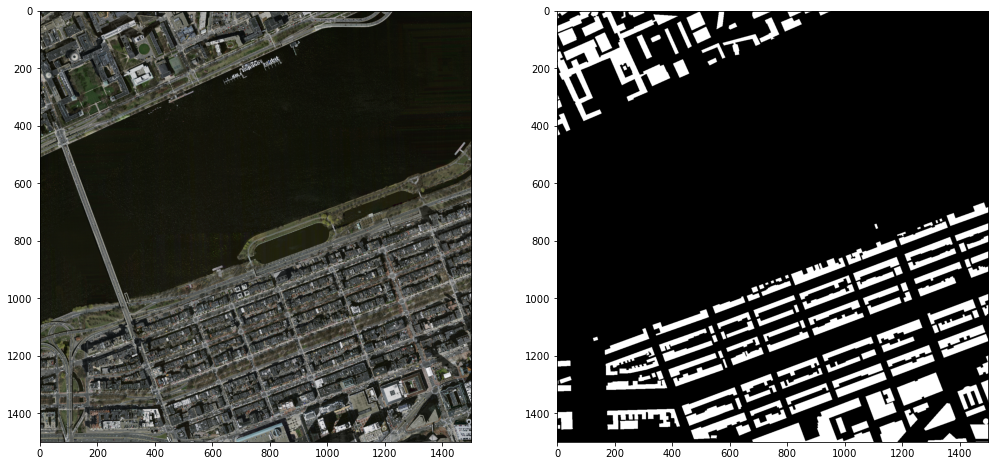

In [4]:
def show_rgb_image(rgb_image, figsize=(10, 10)):
    f, axarr = plt.subplots(figsize=figsize)
    axarr.imshow(rgb_image)

def show_mask_image(mask_image,figsize=(10,10)):
    f,axarr = plt.subplots(figsize=figsize)
    axarr.imshow(mask_image,cmap='gray')

sample_image = np.random.choice(train_images,1)[0]
rgb_image = io.imread(sample_image)
rgb_mask = io.imread(sample_image.replace('train','train_labels')[:-1]) # labels are .tif

plt.figure(figsize=(17,15))
plt.subplot(1,2,1)
plt.imshow(rgb_image)
plt.subplot(1,2,2)
plt.imshow(rgb_mask)

# show_rgb_image(rgb_image)
# show_mask_image(rgb_mask)

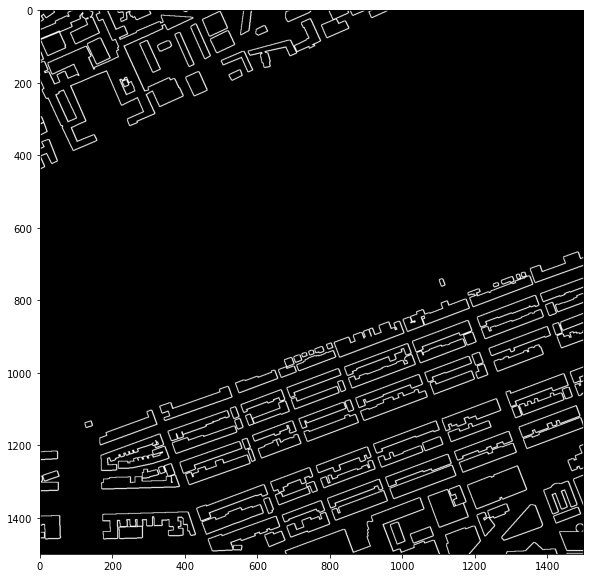

In [7]:
def generate_boundary_mask(instance_mask, boundary_width_pixel):
    instance_mask = cv2.cvtColor(instance_mask,cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE,
        (boundary_width_pixel, boundary_width_pixel)
    )
    h, w = instance_mask.shape
    boundary_mask = np.zeros(shape=[h, w], dtype=np.uint8)
    
    dilated = cv2.dilate(instance_mask,kernel,iterations=1)
    boundary = dilated - instance_mask
    boundary_mask[boundary > 0] = 1

    return boundary_mask


boundary_mask = generate_boundary_mask(rgb_mask, boundary_width_pixel=6)
show_mask_image(boundary_mask)

(1500, 1500, 3)

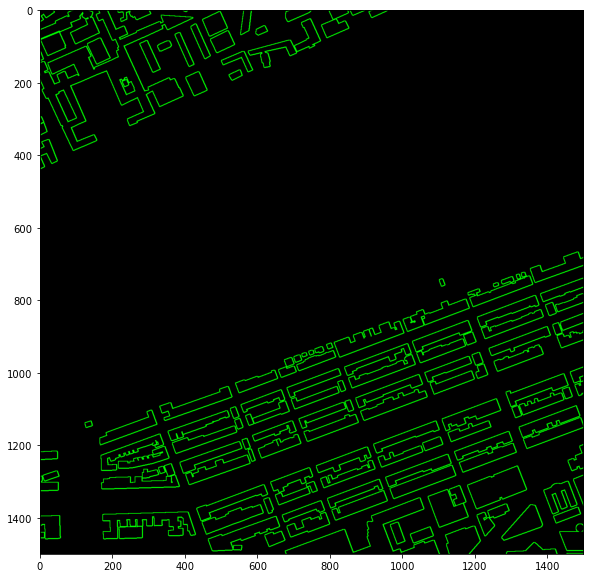

In [8]:
def combine_masks(footprint_mask, boundary_mask):
    combined_mask = np.zeros_like(footprint_mask)
    combined_mask[footprint_mask > 0] = 1
    combined_mask[boundary_mask > 0]  = 2
    return combined_mask  # 0: background, 1: building footprint, 2: building boundary


combined_mask = combine_masks(rgb_mask, boundary_mask)

h, w = boundary_mask.shape
combined_mask_color = np.zeros(shape=(h, w, 3), dtype=np.uint8)
combined_mask_color= np.where(combined_mask == 1,np.asarray([255,0,0]),combined_mask)  # red for building footprint
combined_mask_color = np.where(combined_mask == 2,np.asarray([0,255,0]),combined_mask)
show_rgb_image(combined_mask_color)
combined_mask_color.shape

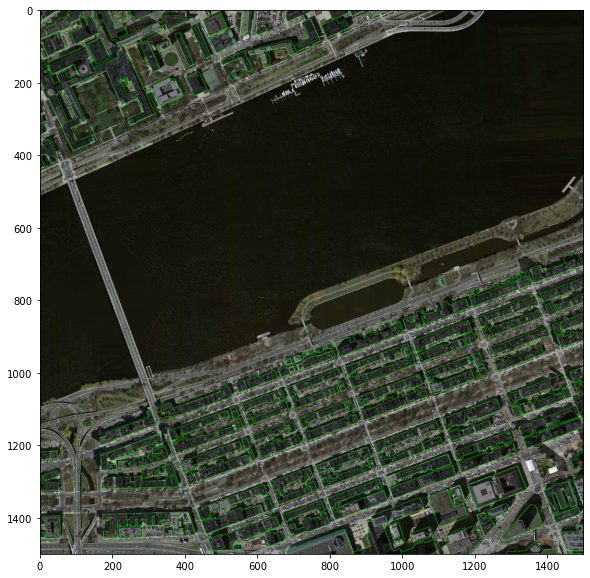

In [9]:
def overlay_mask_on_image(image, mask_color, alpha=0.4):
    ret = image.copy()
    ret[mask_color.sum(axis=-1) > 0] = mask_color[mask_color.sum(axis=-1) > 0]
    ret = cv2.addWeighted(ret, alpha, image, 1 - alpha, 0)
    return ret

rgb_mask_overlayed = overlay_mask_on_image(rgb_image, combined_mask_color)
show_rgb_image(rgb_mask_overlayed)

In [10]:
# combined_mask_color[:,:,1]

# Sapce net data

In [3]:
import os 
import sys
import glob

import json
import numpy as np
import os
import os.path as osp
import cv2
from matplotlib import pyplot as plt  

data_path = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP-detection/data"
fullPathImageDirectory = os.path.join(data_path,"AOI_2_Vegas_Train/RGB-PanSharpen")
fullPathGeoJsonDirectory = os.path.join(data_path,"AOI_2_Vegas_Train/geojson/buildings")

# create Output paths 
outputdirectory = os.path.join(data_path,'output')
output_rgbpath = osp.join(outputdirectory,'RGBImage')
output_annotations = osp.join(outputdirectory,'Mask')

os.makedirs(output_rgbpath,exist_ok=True)
os.makedirs(output_annotations,exist_ok=True)

## Visualization Functions 

In [14]:
def overlay_mask(image, mask, alpha=0.4):
    ret = image.copy()
    # ret[mask_color.sum(axis=-1) > 0] = mask_color[mask_color.sum(axis=-1) > 0]
    ret = cv2.addWeighted(ret, alpha, mask, 1 - alpha, 0)
    return ret


def decode_segmentation_masks(mask, color_map = [255,32,128],n_classes=1):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    #for l in range(0, n_classes):
    idx = mask == 1
    r[idx] = color_map[0]
    g[idx] = color_map[1]
    b[idx] = color_map[2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def read_image_mask(path,mask=False):
    img = cv2.imread(path)
    if mask:
        return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    

def display_images(images,masks, columns=5, width=15, height=17, max_images=15, label_wrap_length=50, label_font_size=8,plot=False):
    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images = images[0:max_images]
        masks  = masks[0:max_images]
    height = max(height, int(len(images)/columns) * height)
    
    plt.figure(figsize=(15, 17))
    i = 0
    final_image = []
    for image,mask in zip(images,masks):
        img = read_image_mask(image)
        label_mask = read_image_mask(mask,mask=True)
        label_mask = decode_segmentation_masks(label_mask)

        overlay = overlay_mask(img,label_mask)
        updated_img = cv2.hconcat([img,label_mask,overlay])
        
        if plot:
            plt.subplot(int(len(images) / columns + 1), columns, i + 1)
            plt.title("image-"+str(i+1))
            plt.tight_layout()
            plt.imshow(updated_img)
        else:
            final_image.append(updated_img)
        i +=1
    return final_image

## Create Mapping functions for Raster images 

In [48]:
from osgeo import gdal, ogr , osr
from genericpath import isfile
import skimage
import subprocess 
from PIL import Image

def convertTo8Bit(rasterImageName, outputRaster,
                  outputPixType='Byte',
                  outputFormat='GTiff',
                  rescale_type='rescale',
                  percentiles=[2, 98]):
    '''
    This does a relatively poor job of converting to 8bit, as opening in qgis
    the images look very different.
    rescale_type = [clip, rescale]
        if resceale, each band is rescaled to its own min and max
        if clip, scaling is done sctricly between 0 65535
    '''

    srcRaster = gdal.Open(rasterImageName)
    nbands = srcRaster.RasterCount
    if nbands == 3:
        cmd = ['gdal_translate', '-ot', outputPixType, '-of', outputFormat,
               '-co', '"PHOTOMETRIC=rgb"']
    else:
        cmd = ['gdal_translate', '-ot', outputPixType, '-of', outputFormat]

    for bandId in range(srcRaster.RasterCount):
        bandId = bandId+1
        band = srcRaster.GetRasterBand(bandId)
        if rescale_type == 'rescale':
            bmin = band.GetMinimum()
            bmax = band.GetMaximum()
            # if not exist minimum and maximum values
            if bmin is None or bmax is None:
                (bmin, bmax) = band.ComputeRasterMinMax(1)
            # else, rescale
            band_arr_tmp = band.ReadAsArray()
            bmin = np.percentile(band_arr_tmp.flatten(), percentiles[0])
            bmax = np.percentile(band_arr_tmp.flatten(), percentiles[1])

        else:
            bmin, bmax = 0, 65535

        cmd.append('-scale_{}'.format(bandId))
        cmd.append('{}'.format(bmin))
        cmd.append('{}'.format(bmax))
        cmd.append('{}'.format(0))
        cmd.append('{}'.format(255))

    cmd.append(rasterImageName)
    cmd.append(outputRaster)
    subprocess.call(cmd)
    return


def create_poly_mask(rasterSrc, vectorSrc, npDistFileName='', noDataValue=0, burn_values=1):
	'''
	Create polygon mask for rasterSrc,
	Similar to labeltools/createNPPixArray() in spacenet utilities
	'''
	## open source vector file that truth data
	source_ds = ogr.Open(vectorSrc)
	source_layer = source_ds.GetLayer()

	## extract data from src Raster File to be emulated
	## open raster file that is to be emulated
	srcRas_ds = gdal.Open(rasterSrc)
	cols = srcRas_ds.RasterXSize
	rows = srcRas_ds.RasterYSize

	if npDistFileName == '':
		dstPath = ".tmp.tiff"
	else:
		dstPath = npDistFileName

	## create First raster memory layer, units are pixels
	# Change output to geotiff instead of memory 
	memdrv = gdal.GetDriverByName('GTiff') 
	dst_ds = memdrv.Create(dstPath, cols, rows, 1, gdal.GDT_Byte, 
						   options=['COMPRESS=LZW'])
	dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
	dst_ds.SetProjection(srcRas_ds.GetProjection())
	band = dst_ds.GetRasterBand(1)
	band.SetNoDataValue(noDataValue)    
	gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[burn_values])
	dst_ds = 0
	mask_image = Image.open(dstPath)
	mask_image = np.array(mask_image)

	if npDistFileName == '':
		os.remove(dstPath)
	return mask_image

In [5]:
listofRaster = sorted(glob.glob(os.path.join(fullPathImageDirectory, '*.tif')))
listofgeojson = sorted(glob.glob(os.path.join(fullPathGeoJsonDirectory, '*.geojson')))

print("Raster images :",len(listofRaster))
print("geojson's :",len(listofgeojson))

if len(listofRaster) != len(listofgeojson):
    print('Error lists do not match fix source errors')

Raster images : 3851
geojson's : 3851


## Convert Raster2RGB-Mask images 

In [ ]:
for rasterImage, geoJson in zip(listofRaster, listofgeojson):    
    if not osp.isfile(osp.join(output_rgbpath,osp.basename(rasterImage))):
        convertTo8Bit(rasterImageName=rasterImage,outputRaster=osp.join(output_rgbpath,osp.basename(rasterImage)))
        mask = create_poly_mask(rasterImage,geoJson)
        mask_file = osp.join(output_annotations,osp.basename(rasterImage).split('.')[0]+'.png') 
        cv2.imwrite(mask_file,mask)

In [6]:
rgb_images = sorted(glob.glob(output_rgbpath+'/*.tif'))
mask_images = sorted(glob.glob(output_annotations+'/*.png'))
data = np.asarray([(rgb,mask) for rgb, mask in zip(rgb_images,mask_images)])

print("RGB IMages ",len(rgb_images))
print("Mask Images ",len(mask_images))
print(data.shape)

RGB IMages  3851
Mask Images  3851
(3851, 2)


Showing 2 images of 3851:


<Figure size 1368x1224 with 0 Axes>

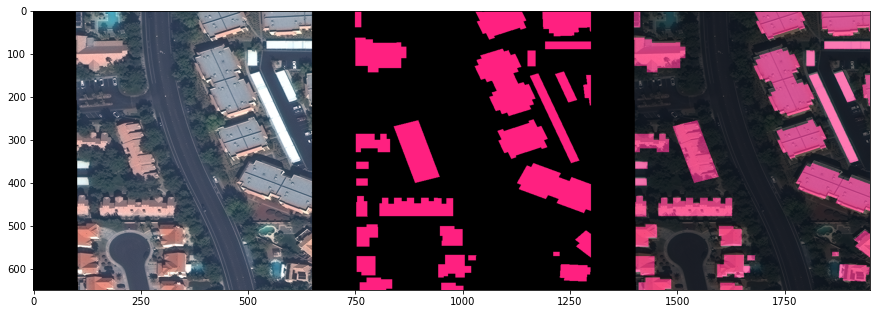

In [15]:
max_display = 2
plt.figure(figsize=(19,17))
images = display_images(rgb_images,mask_images,max_images=max_display,plot=False)
plt.imshow(images[np.random.randint(max_display)])

In [7]:
from sklearn.model_selection import train_test_split

x_train ,x_test = train_test_split(data,train_size=0.80,test_size=0.20)

print("Training data :",x_train.shape[0])
print("Test data :",x_test.shape[0])

Training data : 3080
Test data : 771


## Augmentation of data

In [15]:
import sys 
sys.path.append("/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP-detection/src")
from data_pipeline.data_generator import DataGenerator , transform_data 

# create Train Generator 
train_generator = DataGenerator(image_files = x_train[:,0],mask_files=x_train[:,1],batch_size=1,image_size=512,transform=transform_data())

# create validation Generator
validation_generator = DataGenerator(image_files= x_test[:,0],mask_files=x_test[:,1],batch_size=1,image_size=512)


/home/tandon/anaconda3/envs/pytf/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/tandon/anaconda3/envs/pytf/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


## Visualizing Augmented Training data

In [ ]:
plt.figure(figsize=(10,10))
count = 0
n= 6
for i in range(4):
    Xsample, ysample = train_generator.__getitem__(i)
    
    output_img = ysample[0, :,:,0]
    if count>=n:break 
    count +=1
    plt.subplot(n//2,2,count)
    plt.imshow(Xsample[0])
    count +=1
    plt.subplot(n//2,2,count)
    plt.imshow(output_img,cmap='gray')

### Visualizing validation Data

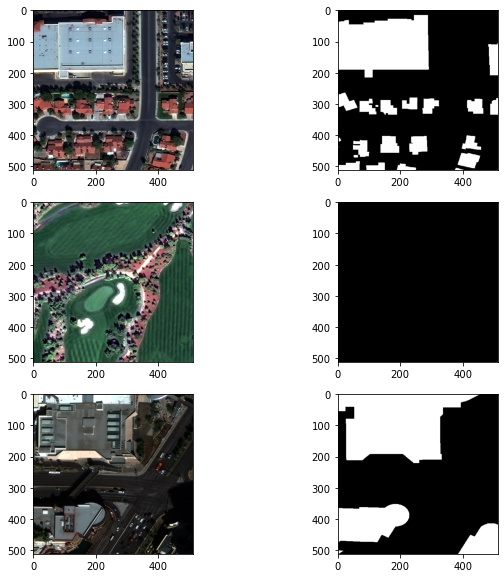

In [27]:
plt.figure(figsize=(10,10))
count = 0
n = 6
for i in range(n):
    Xsample, ysample = validation_generator.__getitem__(i)
    
    output_img = ysample[0, :,:,0]
    if count>=n:break 
    count +=1
    plt.subplot(n//2,2,count)
    plt.imshow(Xsample[0])
    count +=1
    plt.subplot(n//2,2,count)
    plt.imshow(output_img,cmap='gray')

## Plot Truth Co-ordinates

In [87]:
from shapely import geometry
from pygeotile.point import Point
import numpy as np
import rasterio
import geopandas as gpd

def read_tif_image(file):
    with rasterio.open(file) as src:
        image = np.stack([src.read(i+1) for i in range(3)], axis=2)
        transform = src.transform
    return image, transform

def getGeojson(imagePath, maskPath, outfile="result.geojson"):
    image, transform = read_tif_image(imagePath)
    tile_bounds = rasterio.transform.array_bounds(image.shape[0], image.shape[1], transform)
    print(tile_bounds)
    xmin, ymin, xmax, ymax = tile_bounds
    
    mask = cv2.imread(maskPath) 
    mask_nm = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) * 255
    
    hierarchy = cv2.findContours(mask_nm,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    contours = hierarchy[1]
    geo_pix_x = (xmax - xmin) / image.shape[0]
    geo_pix_y = (ymax - ymin) / image.shape[1]
    polygons = []
   
    for c in contours:
        coordinates = []
        for point in c:
            print(point)
            point = point[0]
            x = point[0]
            y = point[1]
            x = (geo_pix_x * x) + xmin
            y =  ymax - (geo_pix_y * y)
            coordinates.append((x,y))
        polygons.append(geometry.Polygon(coordinates))

    polygons_df = gpd.GeoDataFrame(geometry=polygons,crs="EPSG:4326")
    polygons_df.to_file(outfile)
    return polygons_df